# Pipeline draft

In [1]:
import torch
import numpy as np
from omegaconf import OmegaConf
from functools import partial
import gymnasium as gym
import matplotlib.pyplot as plt

import bbrl_utils
from bbrl_utils.notebook import setup_tensorboard
from bbrl.stats import WelchTTest
from bbrl.agents import Agent, Agents, TemporalAgent
from bbrl.agents.gymnasium import ParallelGymAgent, make_env
from bbrl.workspace import Workspace
from bbrl.utils.replay_buffer import ReplayBuffer

import bbrl_gymnasium

from pmind.algorithms import DQN, DDPG, TD3, OfflineTD3
from pmind.losses import dqn_compute_critic_loss, ddqn_compute_critic_loss
from pmind.training import (
    run_dqn, 
    run_ddpg, 
    run_td3, 
    run_td3_offline,
    load_trained_agents,
)
from pmind.replay import (
    collect_policy_transitions, 
    collect_uniform_transitions, 
    mix_transitions, 
    test_rb_compositions,
)

from pmind.visualization import (
    plot_perf_vs_rb_composition_from_dict
)

from pmind.config.loader import load_config

bbrl_utils.setup()

cfg = load_config("bbrl_example")

%load_ext autoreload
%autoreload 2

/Users/vlad/Documents/University/Master-MIND/projet-mind/.venv/lib/python3.10/site-packages/bbrl_utils/notebook.py:46: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # noqa: F401
Using Python 3.10.18 environment at: /Users/vlad/Documents/University/Master-MIND/projet-mind/.venv


In [ ]:
# setup_tensorboard("./outputs/tblogs")

# Obtain transitions

In [15]:
ENV_NAME = [
    "CartPoleContinuous-v1",
    "Pendulum-v1",
    "MountainCarContinuous-v0",
    "LunarLander-v3",
][0]
REWARDS = [113, 225, 375, 500]
BUFFER_SIZE = 100_000
RETRAIN_EXPLOIT = False

## Best policy

Get the best policy and get transitions with it

In [16]:
if RETRAIN_EXPLOIT:
    cfg_td3_exploit = OmegaConf.create(cfg.td3)
    cfg_td3_exploit.gym_env.env_name = ENV_NAME

    # accelerate for the sake of test:
    cfg_td3_exploit.algorithm.max_epochs = 11_000
    cfg_td3_exploit.algorithm.learning_starts = 1000

    # playing with parameters for mountain car:
    cfg_td3_exploit.algorithm.action_noise = 0.3
    cfg_td3_exploit.algorithm.discount_factor = 0.995
    cfg_td3_exploit.actor_optimizer.lr = 1e-4
    cfg_td3_exploit.critic_optimizer.lr = 1e-3
    cfg_td3_exploit.algorithm.tau_target = 0.005

    cfg_td3_exploit.plot_agents=False # TODO: plot_agents() doesn't work with Lunar Lander

    td3 = TD3(cfg_td3_exploit)
    trained_agents = run_td3(td3, save_model_at_rewards=REWARDS)
    td3.visualize_best()
else:
    trained_agents = load_trained_agents(ENV_NAME, REWARDS)

In [ ]:
rb_exploit_by_level = {}
for k, policy_agent in trained_agents.items():
    # TODO: save rbs!
    rb_exploit_by_level[k] = collect_policy_transitions(policy_agent, ENV_NAME, BUFFER_SIZE)

## Uniform exploration

In [5]:
rb_unif = collect_uniform_transitions(ENV_NAME, buffer_size=BUFFER_SIZE)
print(f"Replay buffer with {rb_unif.size()} transitions")

100%|██████████| 100000/100000 [00:07<00:00, 14170.75it/s]

Replay buffer with 100000 transitions


# Offline learning on mixed replay buffer

In [23]:
PROPORTIONS = np.linspace(0,1,10)
SEEDS = [0,1,2,3,4]

In [24]:
cfg_td3_offline = OmegaConf.create(cfg.td3)
cfg_td3_offline.gym_env.env_name = ENV_NAME

# to get 100K training steps:
cfg_td3_offline.algorithm.n_steps = 100
cfg_td3_offline.algorithm.max_epochs = 1000 # TODO: epochs don't actually make sense for offline

# learning starts immediately for offline:
cfg_td3_offline.algorithm.learning_starts = None

# there is no exploration in offline learning 
cfg_td3_offline.algorithm.action_noise = None
cfg_td3_offline.algorithm.target_policy_noise = None

cfg_td3_offline.plot_agents=False # TODO: plot_agents() doesn't work with Lunar Lander

In [ ]:
# ACCELERATE FOR THE TEST: 
cfg_td3_offline.algorithm.n_steps = 10
cfg_td3_offline.algorithm.max_epochs = 10
cfg_td3_offline.algorithm.eval_interval = 2
cfg_td3_offline.algorithm.nb_evals= 5

performances = {}
for k, rb_exploit in rb_exploit_by_level.items():
    # TODO: find a way to temporarily silence tqdm
    performances[k] = test_rb_compositions(
        rb_unif=rb_unif,
        rb_exploit=rb_exploit,
        buffer_size=BUFFER_SIZE,
        proportions=PROPORTIONS,
        agent_constructor=OfflineTD3,
        cfg=cfg_td3_offline,
        offline_run=run_td3_offline,
        seeds=SEEDS # TODO: make buffer mixing take this seed as well
    ) 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

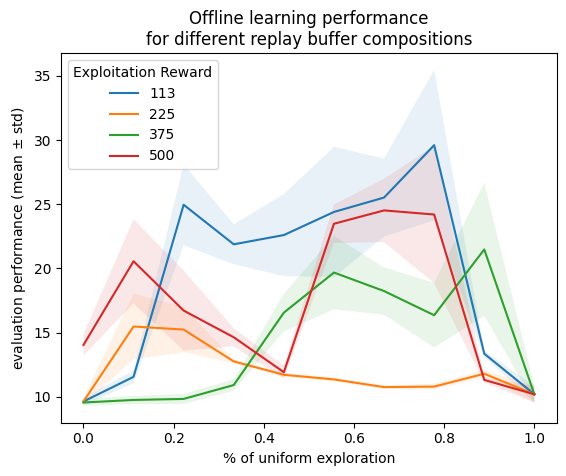

In [29]:
plot_perf_vs_rb_composition_from_dict(
    PROPORTIONS, 
    performances,
    last_n=1, # NOTE: depends on evaluation interval
    legend_title="Exploitation Reward",
    fig_name=f"{ENV_NAME}-offline-diff-best-policies-test.pdf")